# <font color="orange"> Logistic Regression Project: Diabetes Prediction </font>

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import itertools

# for solve problem of show plotly plots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

from warnings import filterwarnings
filterwarnings('ignore')
plt.style.use('_mpl-gallery')

In [2]:
from sklearn.model_selection import train_test_split , GridSearchCV, KFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn import metrics


In [3]:
# import diabetes dataset
data = pd.read_csv("../input/diabetes/diabetes.csv")
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# <font color='orange'> 1. Dataset Overview </font>

In [4]:
df = pd.DataFrame(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


# <font color='orange'> 2. Cleaning and Preparing Data </font>

In [5]:
df.isnull().sum()
# df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
outcome                     0
dtype: int64

We have 9 columns, none of which seem to have missing values

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [7]:
df.duplicated().sum()

0

Ok There is no duplicate data

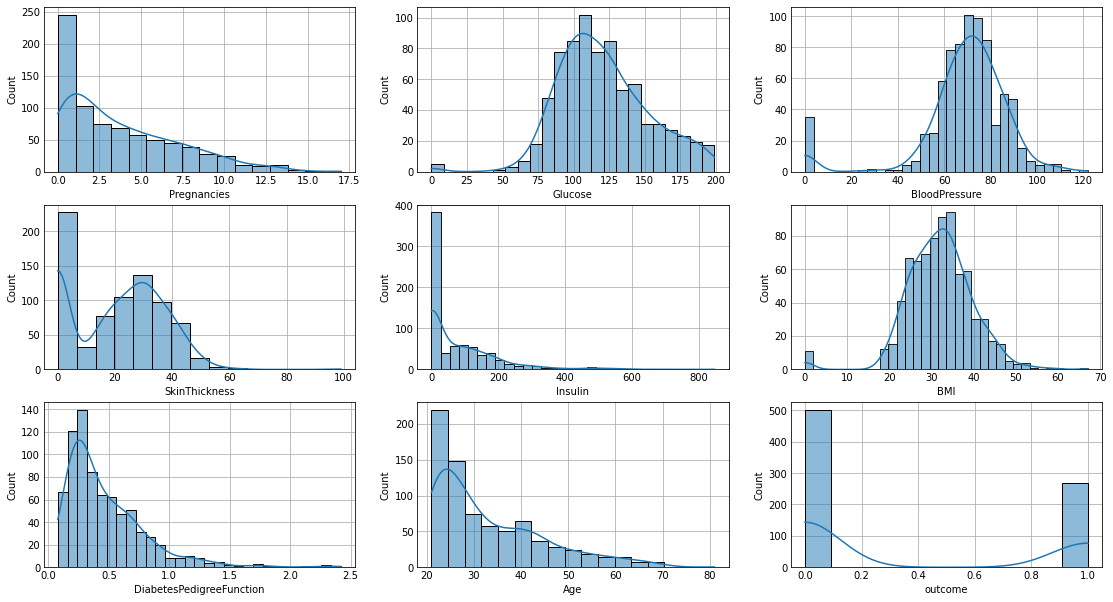

In [8]:
# Now draw plots and check the noisy data:
# first we check the data distribution:
%matplotlib inline
fig, ax = plt.subplots(3,3,figsize=(15,9))
for i, col in enumerate(df):
    sns.histplot(df[col], kde=True, ax=ax[i//3, i%3])
    # plt.title(f"{col} ditribution", fontsize=14, fontweight='bold', c='r')
plt.show()

In [9]:
df1 = df.copy()
zero_col = ['Glucose','Insulin','SkinThickness','BloodPressure','BMI']
df1[zero_col] = df1[zero_col].replace(0, np.nan)

In [10]:
df1.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
outcome                       0
dtype: int64

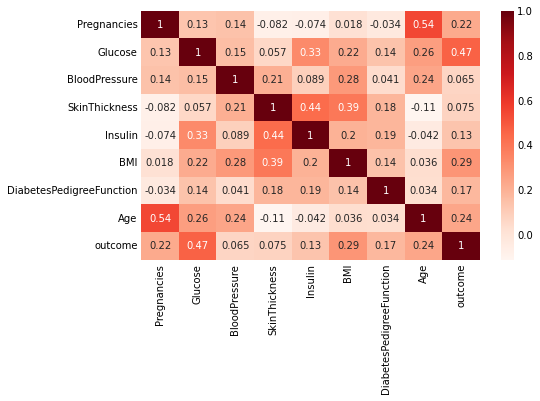

In [11]:
%matplotlib inline
sns.heatmap(data.corr(), annot=True, cmap='Reds')
plt.show()

- I don't have expertise or science in medicine, but I think that glucose, insulin, skin thickness, blood pressure, and BMI cannot have a zero value, and since I don't have access to the owner of the data to research this data, so I have to fill or drop these data
- The features do not have much correlation with each other and therefore they cannot be filled according to each other. Also, since the number of false zero data is high, removing them is not a good solution so I fill them according to distribution data
- Mean is most useful when the original data is not skewed, while the median is more robust, not sensitive to outliers, and thus used when data is skewed.
- As can be seen in the data distribution charts, insulin, glucose and skin thickness are deviated to the right and left, so we fill them with Madin. On the other hand, BMI and blood pressure have a normal distribution and we use the average to fill them 

In [12]:
for col in ['Glucose','Insulin','SkinThickness']:
    median_col = np.median(df1[df1[col].notna()][col])
    df1[col] = df1[col].fillna(median_col)
for col in ['BMI','BloodPressure']:
    mean_col = np.mean(df1[df1[col].notna()][col])
    df1[col] = df1[col].fillna(mean_col)

In [13]:
df1.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
outcome                     0
dtype: int64

In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


# <font color="orange"> 3.Exploratory Data Analysis (EDA) </font>

### <font color="orange"> 3.1.Univariate Analysis: </font>

In [15]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.000000,6.00000,17.00
Glucose,768.0,121.656250,30.438286,44.000,99.75000,117.000000,140.25000,199.00
BloodPressure,768.0,72.405184,12.096346,24.000,64.00000,72.202592,80.00000,122.00
SkinThickness,768.0,29.108073,8.791221,7.000,25.00000,29.000000,32.00000,99.00
Insulin,768.0,140.671875,86.383060,14.000,121.50000,125.000000,127.25000,846.00
BMI,768.0,32.457464,6.875151,18.200,27.50000,32.400000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.372500,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.000000,41.00000,81.00
outcome,768.0,0.348958,0.476951,0.000,0.00000,0.000000,1.00000,1.00


- According to above table, Most people in this dataset do not have diabetes.

#### <font color="orange"> 3.2.Numeric - Numeric Bivariate Analysis: </font>

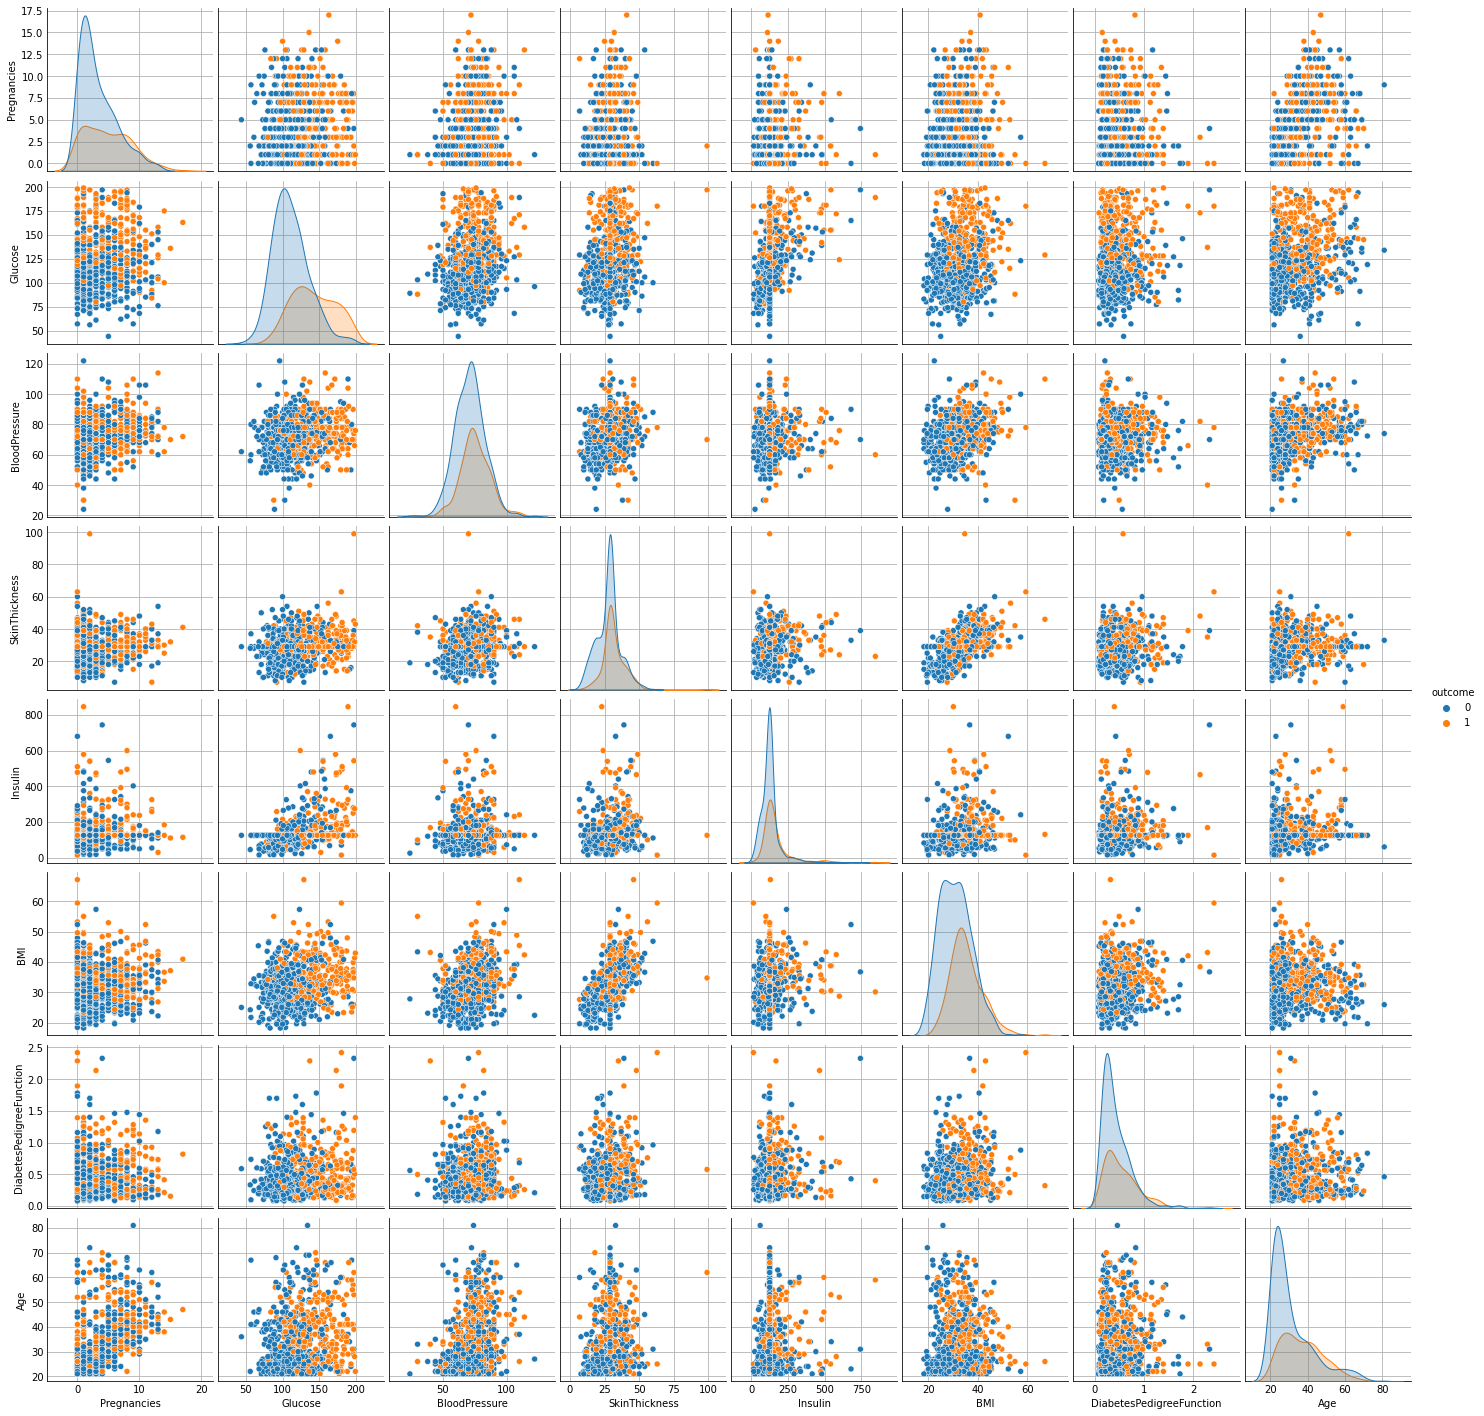

In [16]:
%matplotlib inline
sns.pairplot(data=df1, diag_kind='kde', hue='outcome')
plt.show()

In [17]:
fig = go.Figure()
my_cols = ['Pregnancies','Glucose','BloodPressure','SkinThickness',
           'Insulin','BMI','DiabetesPedigreeFunction','Age']
for col in my_cols:
    fig.add_trace(go.Box(y=df1[col], name=f'{col}'))
fig.show()

# <font color='orange'> 4.Model </font>

In [18]:
df1

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0
764,2,122.0,70.0,27.0,125.0,36.8,0.340,27,0
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0
766,1,126.0,60.0,29.0,125.0,30.1,0.349,47,1


In [19]:
# define x and y for modeling
x = df1.drop('outcome', axis=1)
y = df1.outcome

In [20]:
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)
x_norm

array([[ 0.63994726,  0.86604475, -0.03351824, ...,  0.16629174,
         0.46849198,  1.4259954 ],
       [-0.84488505, -1.20506583, -0.52985903, ..., -0.85253118,
        -0.36506078, -0.19067191],
       [ 1.23388019,  2.01666174, -0.69530596, ..., -1.33283341,
         0.60439732, -0.10558415],
       ...,
       [ 0.3429808 , -0.02157407, -0.03351824, ..., -0.91074963,
        -0.68519336, -0.27575966],
       [-0.84488505,  0.14279979, -1.02619983, ..., -0.34311972,
        -0.37110101,  1.17073215],
       [-0.84488505, -0.94206766, -0.19896517, ..., -0.29945588,
        -0.47378505, -0.87137393]])

In [21]:
# convert x_train_st to DataFrame
x = pd.DataFrame(x_norm, index=x.index, columns=x.columns)
x

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.866045,-0.033518,0.670643,-0.181541,0.166292,0.468492,1.425995
1,-0.844885,-1.205066,-0.529859,-0.012301,-0.181541,-0.852531,-0.365061,-0.190672
2,1.233880,2.016662,-0.695306,-0.012301,-0.181541,-1.332833,0.604397,-0.105584
3,-0.844885,-1.073567,-0.529859,-0.695245,-0.540642,-0.634212,-0.920763,-1.041549
4,-1.141852,0.504422,-2.680669,0.670643,0.316566,1.548980,5.484909,-0.020496
...,...,...,...,...,...,...,...,...
763,1.827813,-0.679069,0.297376,2.150354,0.455573,0.064409,-0.908682,2.532136
764,-0.547919,0.011301,-0.198965,-0.239949,-0.181541,0.632039,-0.398282,-0.531023
765,0.342981,-0.021574,-0.033518,-0.695245,-0.332132,-0.910750,-0.685193,-0.275760
766,-0.844885,0.142800,-1.026200,-0.012301,-0.181541,-0.343120,-0.371101,1.170732


In [22]:
# split data to train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [23]:
FPR1 = []
TPR1 = []
FPR0 = []
TPR0 = []
ACC = []
Recall = []
Precision = []
F1 = []

def plot_confusion_matrix2(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
        cm(array): confusion matrix
        classes(dictionary): classes in our target
    """
    plt.figure(figsize=(10,7))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt ='d'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

# --------------------------------------------------------------------------------------

def Perform_cross_val(model, k, x, y, scoring):
    """
    perform cross validation
        model: logistic model
        k(scaler): the value for n_splits in KFold()
        x(DataFrame or array):  x_train
        y(DataFrame or array): y_train
        scoring(string): an approach for evaluation in cross validation
    """

    kf = KFold(n_splits=k)
    cv_results = cross_val_score(model, x, y, cv=kf, scoring=scoring)
    cv_mean = np.mean(cv_results)
    print('-'*20, f"CV for k={k}, scoring={scoring}", '-'*20)
    print(f"CV mean: {cv_mean}")
    print(f"CV results: {cv_results}\n")

# --------------------------------------------------------------------------------------

def find_fold_index(k, x):
    """
    Find fold index in kfold
        k(scaler): the value used for n_splits in KFold()
        x(DataFrame or array): x_train
    """

    my_fold_index = []
    j=1
    for _ , test in KFold(k).split(x):

        my_fold_index = []
        for i in test:
            my_fold_index.append(i)
        print(f"fold {j}: [{my_fold_index[0]},{my_fold_index[-1]}]")
        print(20*'-')
        j += 1

# --------------------------------------------------------------------------------------

def features_importance(model, x_test):
    """
    print feature weights and show imporance of each feature
        model: logistic regression
        x_test(Dataframe)
    """
    print('-'*20 , 'Feature', '-'*20)
    coeff = list(model.coef_[0])
    labels = list(x_test.columns)
    features = pd.DataFrame()
    features['Features'] = labels + ['Intercept']
    features['Importance'] = coeff + [model.intercept_[0]]
    features.sort_values(by=['Importance'], ascending=True, inplace=True)
    features['Positive'] = features['Importance'] > 0
    features.set_index('Features', inplace=True)
    features.Importance.plot(kind='barh', figsize=(5,3), 
                             color=features.Positive.map({True:'green', False:'orange'}))
    plt.xlabel('Importance')
    plt.show()
    return features

# --------------------------------------------------------------------------------------

def plot_results(FPR0, TPR0, FPR1, TPR1, ACC, Recall, Precision, F1):
    """
    draw ROC curve and plot of Recall, precision, f1 score etc.
        FPR0(list): list of False Positive Rate for class 0
        TPR0(list): list of True Positive Rate for class 0
        FPR1(list): list of Flase Positive Rate for class 1
        TPR1(list): list of True Positive Rate for class 1
        ACC(list): list of accuracy of models
        Recall(list): list of recall score of models
        Precision(list): list of Precision score of models
        F1(list): list of F1 score of models 
    """
    fig, ax = plt.subplots(1,3,figsize=(15,4))
    # plot model evaluation
    ax[0].set_title('Model Evaluation Results', fontsize=14, fontweight='bold')
    sns.lineplot(data=pd.DataFrame({'accoracy': ACC, 'Recall': Recall,
                                    'Precision': Precision, 'F1 score': F1}), 
                                    markers=True, ax=ax[0])
    ax[0].set_xlabel('M')
    ax[0].set_ylabel('Evaluation')
    ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
          fancybox=True, shadow=True)

    # plot ROC curve for class 1
    i=1
    ax[1].set_title('ROC Curve of Class 1', fontsize=14, fontweight='bold')
    for fpr , tpr in zip(FPR1, TPR1):
        ax[1].plot(fpr, tpr, label=f"ROC curve of model{i} (AUC = {round(metrics.auc(fpr, tpr),3)})")
        i += 1
        ax[1].set_xlabel('FPR')
        ax[1].set_ylabel('TPR')
    ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
          fancybox=True, shadow=True)
        
    # plot ROC curve for class zero
    i=1
    ax[2].set_title('ROC Curve of Class 0', fontsize=14, fontweight='bold')
    for fpr , tpr in zip(FPR0, TPR0):
        ax[2].plot(fpr, tpr, '--', label=f"ROC curve of model{i} (AUC = {round(metrics.auc(fpr, tpr),3)})")
        i += 1
        ax[2].set_xlabel('FPR')
        ax[2].set_ylabel('TPR')
    ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
        fancybox=True, shadow=True)
    
    plt.show()

# --------------------------------------------------------------------------------------

def modeling(x, y, test_size, classes, parameters, is_add=1 ):

    # split data to train and test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=0)

    # define model and fit model
    logreg = LogisticRegression(solver=parameters['solver'], penalty=parameters['penalty'],
                                C=parameters['C'], n_jobs=-1)
    logreg.fit(x_train, y_train)

    # prediction and results
    y_pred = logreg.predict(x_test)
    y_pred_proba = logreg.predict_proba(x_test)
    cm = confusion_matrix(y_test, y_pred, labels=[1,0])
    fpr1, tpr1, _ = metrics.roc_curve(y_test, y_pred_proba[:,1])
    fpr0, tpr0, _ = metrics.roc_curve(y_test, y_pred_proba[:,0])
    acc = metrics.accuracy_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    pre = metrics.precision_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)

    # append results
    if is_add == 1:
        FPR0.append(fpr0)
        TPR0.append(tpr0)
        FPR1.append(fpr1)
        TPR1.append(tpr1)
        ACC.append(acc)
        Recall.append(rec)
        Precision.append(pre)
        F1.append(f1)

    plot_results(FPR0, TPR0, FPR1, TPR1, ACC, Recall, Precision, F1)

    # Evaluation model
    print('-'*20 , 'Confusion Matrix', '-'*20)
    print(cm)
    plot_confusion_matrix2(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
    # or use plot_confusion_matrix from sklearn.metrics
    print('-'*20 , 'Classification Report', '-'*20)
    print(classification_report(y_test, y_pred, target_names=classes), '\n')
    print(f"Jaccard Score: {metrics.jaccard_score(y_test, y_pred)}", '\n')

    # print other result about weight and predicted data
    return logreg, acc, features_importance(logreg, x_test)

In [24]:
# define model
logreg = LogisticRegression(solver='liblinear')

# check cross validation
cross5_acc = Perform_cross_val(logreg, 5, x_train, y_train, 'accuracy')
cross10_acc = Perform_cross_val(logreg, 10, x_train, y_train, 'accuracy')

-------------------- CV for k=5, scoring=accuracy --------------------
CV mean: 0.7622417699586832
CV results: [0.71544715 0.82113821 0.73170732 0.76422764 0.77868852]

-------------------- CV for k=10, scoring=accuracy --------------------
CV mean: 0.7539925965097832
CV results: [0.74193548 0.67741935 0.87096774 0.77419355 0.72131148 0.72131148
 0.78688525 0.70491803 0.7704918  0.7704918 ]



The values of the folds are close to each other and no problem

Now create model for test_size = 0.2

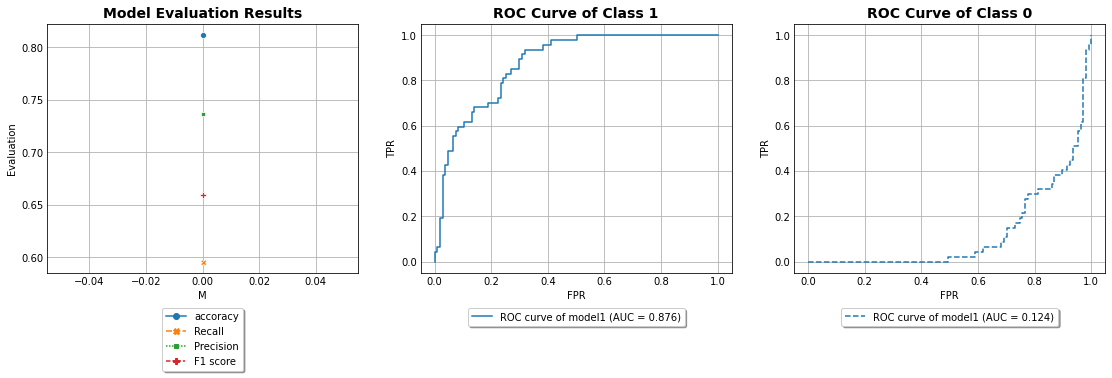

-------------------- Confusion Matrix --------------------
[[28 19]
 [10 97]]


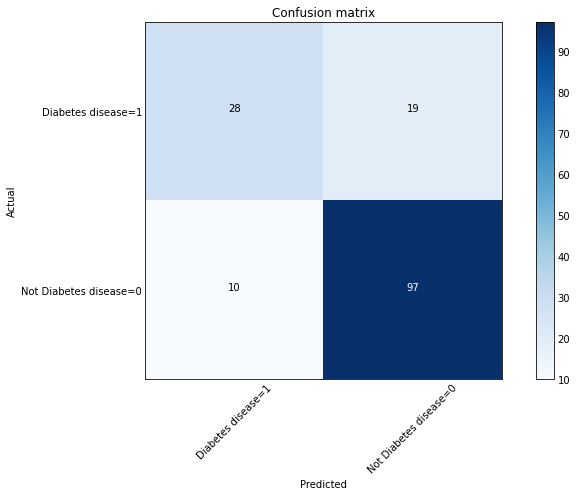

-------------------- Classification Report --------------------
                        precision    recall  f1-score   support

    Diabetes disease=1       0.84      0.91      0.87       107
Not Diabetes disease=0       0.74      0.60      0.66        47

              accuracy                           0.81       154
             macro avg       0.79      0.75      0.76       154
          weighted avg       0.81      0.81      0.81       154
 

Jaccard Score: 0.49122807017543857 

-------------------- Feature --------------------


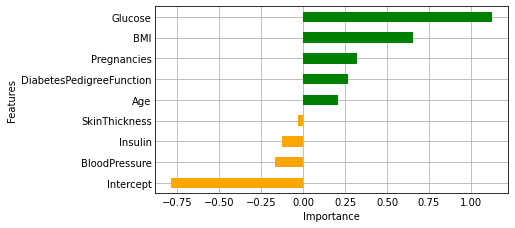

,Importance,Positive
Features,,
Intercept,-0.786687,False
BloodPressure,-0.168136,False
Insulin,-0.124854,False
SkinThickness,-0.032333,False
Age,0.208669,True
DiabetesPedigreeFunction,0.265662,True
Pregnancies,0.321907,True
BMI,0.656904,True
Glucose,1.125913,True


In [25]:
%matplotlib inline
parameters = dict(solver='liblinear' ,penalty='l2',C=1)
model, acc, features = modeling(x, y, 0.2, ['Diabetes disease=1', 'Not Diabetes disease=0'], parameters, is_add=1)
features

The obtained results are relatively good, but we will continue to improve the performance of the model

In [26]:
x

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.866045,-0.033518,0.670643,-0.181541,0.166292,0.468492,1.425995
1,-0.844885,-1.205066,-0.529859,-0.012301,-0.181541,-0.852531,-0.365061,-0.190672
2,1.233880,2.016662,-0.695306,-0.012301,-0.181541,-1.332833,0.604397,-0.105584
3,-0.844885,-1.073567,-0.529859,-0.695245,-0.540642,-0.634212,-0.920763,-1.041549
4,-1.141852,0.504422,-2.680669,0.670643,0.316566,1.548980,5.484909,-0.020496
...,...,...,...,...,...,...,...,...
763,1.827813,-0.679069,0.297376,2.150354,0.455573,0.064409,-0.908682,2.532136
764,-0.547919,0.011301,-0.198965,-0.239949,-0.181541,0.632039,-0.398282,-0.531023
765,0.342981,-0.021574,-0.033518,-0.695245,-0.332132,-0.910750,-0.685193,-0.275760
766,-0.844885,0.142800,-1.026200,-0.012301,-0.181541,-0.343120,-0.371101,1.170732


# <font color='orange'> 5.Improve Model </font>

In [27]:
# we improve model by ذringing some features to the power of 3
# we have negative number so we can not use dim=2
dim = 3
for col in features.index.tolist()[1:]:
    new_col = f"{col}_{dim}"
    x[new_col] = x[col] ** dim
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
    logreg = LogisticRegression(solver='liblinear')
    logreg.fit(x_train, y_train)
    accuracy = metrics.accuracy_score(y_test, logreg.predict(x_test))
    if accuracy <= acc:
        x.drop(new_col, axis=1, inplace=True)
    else:
        acc = accuracy
        parameters = dict(solver='liblinear' ,penalty='l2',C=1)
        modeling(x, y, 0.2, ['Diabetes disease=1', 'Not Diabetes disease=0'], parameters, is_add=1)


In [28]:
x

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.866045,-0.033518,0.670643,-0.181541,0.166292,0.468492,1.425995
1,-0.844885,-1.205066,-0.529859,-0.012301,-0.181541,-0.852531,-0.365061,-0.190672
2,1.233880,2.016662,-0.695306,-0.012301,-0.181541,-1.332833,0.604397,-0.105584
3,-0.844885,-1.073567,-0.529859,-0.695245,-0.540642,-0.634212,-0.920763,-1.041549
4,-1.141852,0.504422,-2.680669,0.670643,0.316566,1.548980,5.484909,-0.020496
...,...,...,...,...,...,...,...,...
763,1.827813,-0.679069,0.297376,2.150354,0.455573,0.064409,-0.908682,2.532136
764,-0.547919,0.011301,-0.198965,-0.239949,-0.181541,0.632039,-0.398282,-0.531023
765,0.342981,-0.021574,-0.033518,-0.695245,-0.332132,-0.910750,-0.685193,-0.275760
766,-0.844885,0.142800,-1.026200,-0.012301,-0.181541,-0.343120,-0.371101,1.170732


Since the performance of the model did not change much, exponentiation has no effect.

Now tuning hyperparameter for logistic regression for improve model

In [29]:
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, random_state=0)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train, y_train)
# summarize results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} ({stdev}) with: {param}")

Best: 0.7582707562136436 using {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.7577868852459015 (0.058276888692476665) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.7577868852459015 (0.058276888692476665) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.7577868852459015 (0.058276888692476665) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.7577868852459015 (0.058276888692476665) with: {'C': 100, 'penalty': 'l2', 'solver': 'sag'}
0.7577868852459015 (0.058276888692476665) with: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
0.7576229508196719 (0.05840218730112301) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.7576229508196719 (0.05840218730112301) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.7577868852459015 (0.058276888692476665) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.7576229508196719 (0.05840218730112301) with: {'C': 10, 'penalty': 'l2', 'solver': 'sag'}
0.7576229508196719 (0.05840218730112301) with: {'C': 10, '

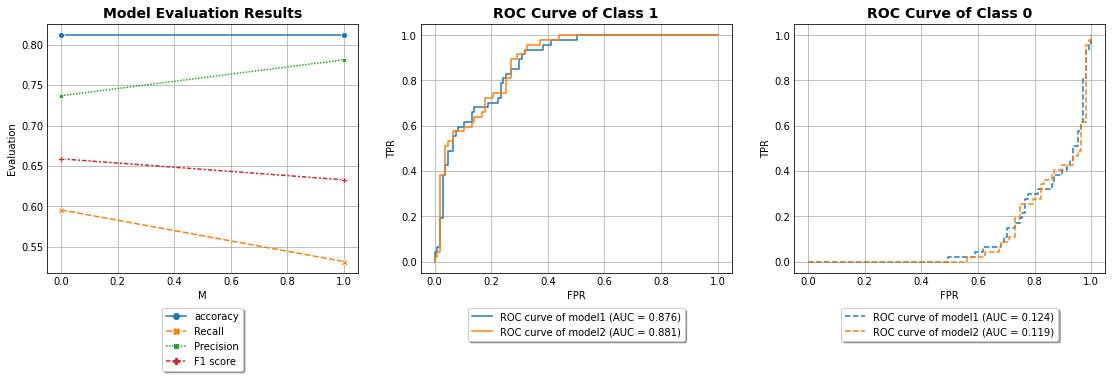

-------------------- Confusion Matrix --------------------
[[ 25  22]
 [  7 100]]


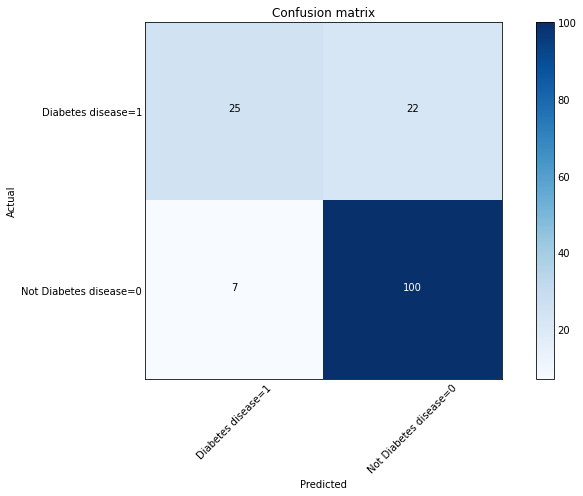

-------------------- Classification Report --------------------
                        precision    recall  f1-score   support

    Diabetes disease=1       0.82      0.93      0.87       107
Not Diabetes disease=0       0.78      0.53      0.63        47

              accuracy                           0.81       154
             macro avg       0.80      0.73      0.75       154
          weighted avg       0.81      0.81      0.80       154
 

Jaccard Score: 0.46296296296296297 

-------------------- Feature --------------------


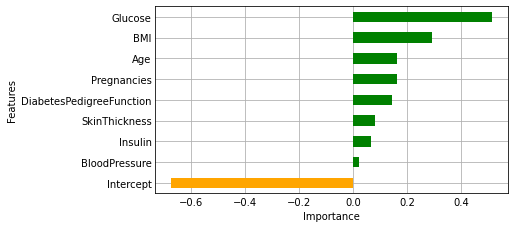

,Importance,Positive
Features,,
Intercept,-0.672767,False
BloodPressure,0.022690,True
Insulin,0.065538,True
SkinThickness,0.078961,True
DiabetesPedigreeFunction,0.143067,True
Pregnancies,0.161970,True
Age,0.162989,True
BMI,0.292526,True
Glucose,0.513293,True


In [30]:
parameters = dict(grid_result.best_params_)
model, _, features = modeling(x, y, 0.2, ['Diabetes disease=1', 'Not Diabetes disease=0'], parameters, is_add=1)
features

try imporve model by dot product some features

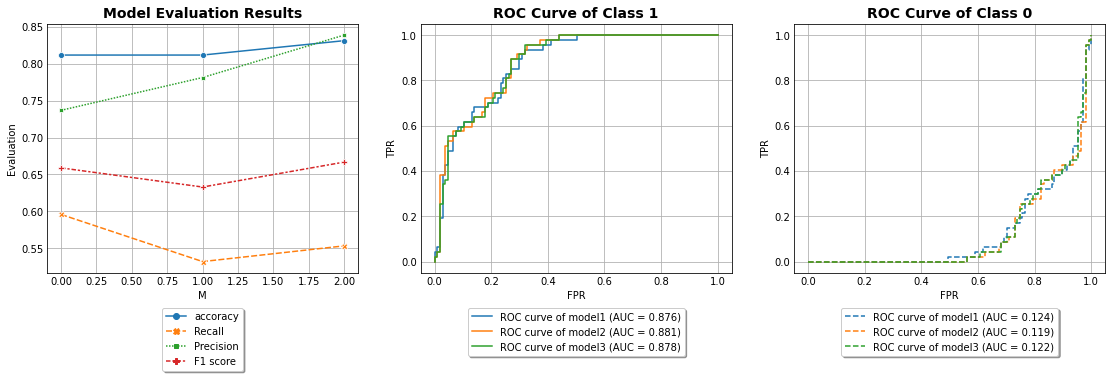

-------------------- Confusion Matrix --------------------
[[ 26  21]
 [  5 102]]


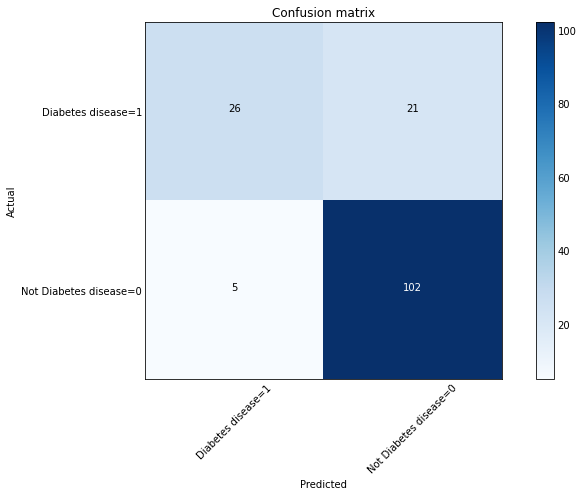

-------------------- Classification Report --------------------
                        precision    recall  f1-score   support

    Diabetes disease=1       0.83      0.95      0.89       107
Not Diabetes disease=0       0.84      0.55      0.67        47

              accuracy                           0.83       154
             macro avg       0.83      0.75      0.78       154
          weighted avg       0.83      0.83      0.82       154
 

Jaccard Score: 0.5 

-------------------- Feature --------------------


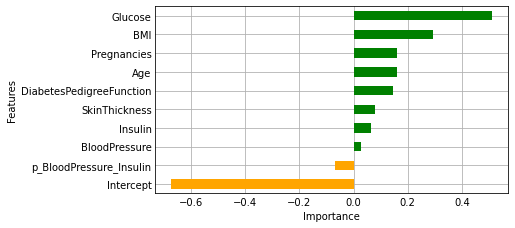

In [31]:
x['p_BloodPressure_Insulin'] = x.BloodPressure * x.Insulin
model, _, features = modeling(x, y, 0.2, ['Diabetes disease=1', 'Not Diabetes disease=0'], parameters, is_add=1)

Now testing model for test_size =0.3 and 0.25

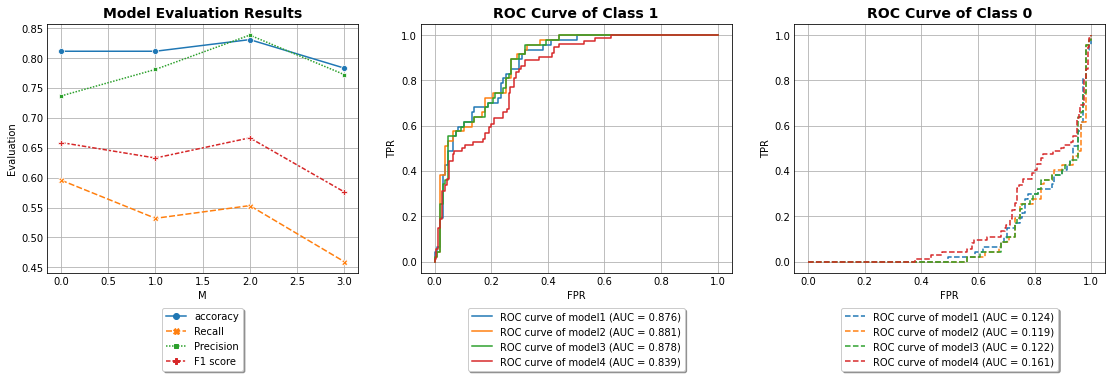

-------------------- Confusion Matrix --------------------
[[ 34  40]
 [ 10 147]]


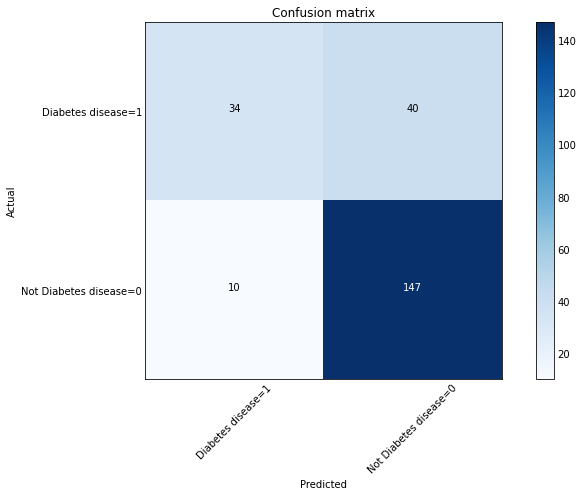

-------------------- Classification Report --------------------
                        precision    recall  f1-score   support

    Diabetes disease=1       0.79      0.94      0.85       157
Not Diabetes disease=0       0.77      0.46      0.58        74

              accuracy                           0.78       231
             macro avg       0.78      0.70      0.72       231
          weighted avg       0.78      0.78      0.77       231
 

Jaccard Score: 0.40476190476190477 

-------------------- Feature --------------------


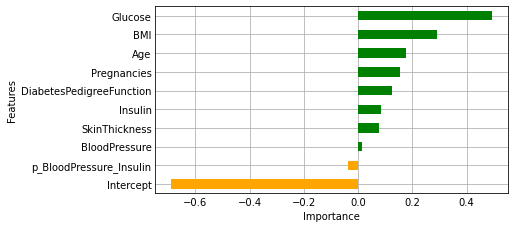

In [32]:
model, _, features = modeling(x, y, 0.3, ['Diabetes disease=1', 'Not Diabetes disease=0'], parameters, is_add=1)

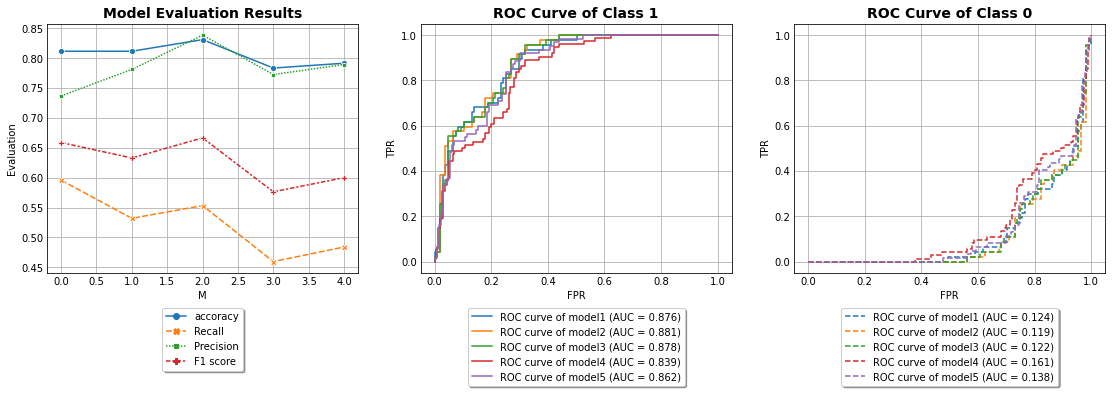

-------------------- Confusion Matrix --------------------
[[ 30  32]
 [  8 122]]


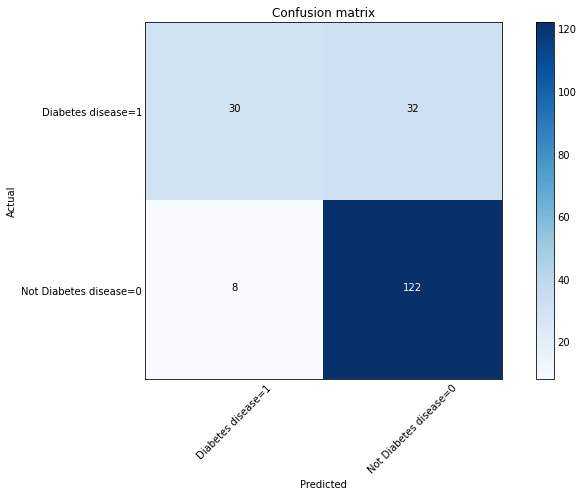

-------------------- Classification Report --------------------
                        precision    recall  f1-score   support

    Diabetes disease=1       0.79      0.94      0.86       130
Not Diabetes disease=0       0.79      0.48      0.60        62

              accuracy                           0.79       192
             macro avg       0.79      0.71      0.73       192
          weighted avg       0.79      0.79      0.78       192
 

Jaccard Score: 0.42857142857142855 

-------------------- Feature --------------------


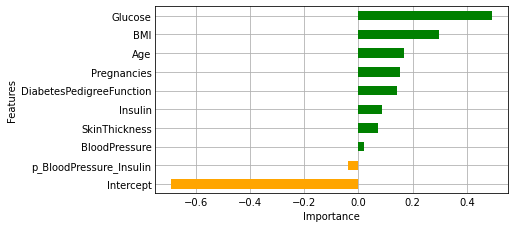

In [33]:
model, acc, features = modeling(x, y, 0.25, ['Diabetes disease=1', 'Not Diabetes disease=0'], parameters, is_add=1)

As seen, the best model was the one obtained with a test size = 0.2

In [34]:
# for prevent repeat model 3 that has better result we
# delete model 3 and now fit model again as the final model so:
del FPR1[2]
del TPR1[2]
del FPR0[2]
del TPR0[2]
del ACC[2]
del Recall[2]
del Precision[2]
del F1[2]

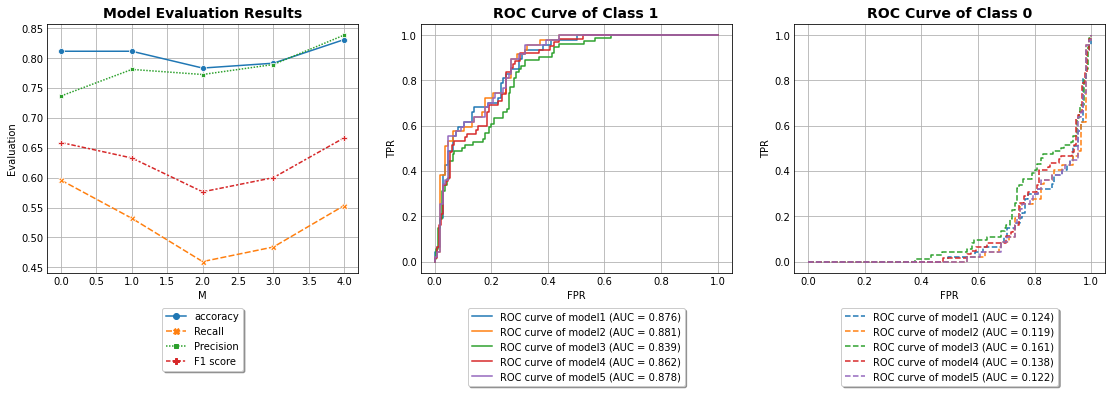

-------------------- Confusion Matrix --------------------
[[ 26  21]
 [  5 102]]


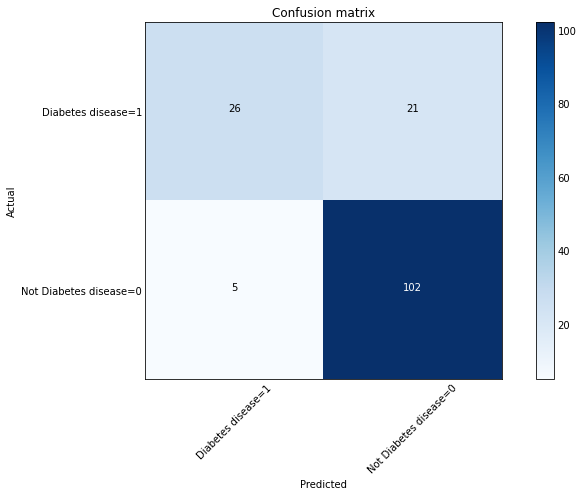

-------------------- Classification Report --------------------
                        precision    recall  f1-score   support

    Diabetes disease=1       0.83      0.95      0.89       107
Not Diabetes disease=0       0.84      0.55      0.67        47

              accuracy                           0.83       154
             macro avg       0.83      0.75      0.78       154
          weighted avg       0.83      0.83      0.82       154
 

Jaccard Score: 0.5 

-------------------- Feature --------------------


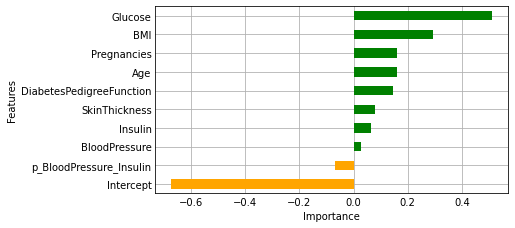

,Importance,Positive
Features,,
Intercept,-0.672547,False
p_BloodPressure_Insulin,-0.069044,False
BloodPressure,0.026634,True
Insulin,0.065816,True
SkinThickness,0.080283,True
DiabetesPedigreeFunction,0.144212,True
Age,0.161389,True
Pregnancies,0.161395,True
BMI,0.294566,True


In [35]:
# modeling final model that is better model
model, _, features = modeling(x, y, 0.2, ['Diabetes disease=1', 'Not Diabetes disease=0'], parameters, is_add=1)
features

So model 5 is our best model

# <font color='orange'> 6. Visualization Final Model </font>

In [36]:
%matplotlib inline
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_test.insert(9,'outcome', y_test)
cols = ['Age','BloodPressure','Insulin','SkinThickness','DiabetesPedigreeFunction','Pregnancies','BMI']
for col in cols:

    fig = px.scatter_3d(
        data_frame= x_test,
        x=x_test.Glucose,
        y=x_test[col],
        z=x_test.outcome,
        color=model.predict(x_test.drop('outcome', axis=1)).astype(str),
        color_discrete_sequence={0:'red', 1:'green'},
        template='ggplot2',
        hover_name='Age',
        # hover_data=
        opacity=0.6,
        # symbol='Transmission',
        # symbol_map=
        # log_x=True,
        # log_z=True,
        height=700,
        title=f'Visualization Performance of Model in Predicting')

    pio.show(fig)

As can be seen in the above 3D scatter and confusion matrix, the model does not perform as well as class one in class zero.

#### THE END

Thanks for your attention :)